<a href="https://colab.research.google.com/github/Martin-Elizalde/Ideas-Climate-Environment/blob/main/DroughtModelAllMunShort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NEURAL NETWORK TO PREDICT DROUGHT LEVELS IN MUNICIPALITIES BASED ON DATA FROM THE NORTH AMERICAN DROUGHT MONITOR (MEXICO)**

*Notes on the code:*
The following is done with Tensorflow 2.0 and keras, it shows a Neural Network architecture for multiple simultaneous training of a classification problem with multiple softmax activations. This code is one approach to the problem, any comments for improvement, errors being spotted or suggestions of different options are welcomed!, this is meant as a proof of concept but it certainly works. Read the conclusions for more insight.

Based on the North American Drought Monitor (https://www.ncdc.noaa.gov/temp-and-precip/drought/nadm/), Mexico publishes data of his territory per municipality in their own website (https://smn.conagua.gob.mx/es/climatologia/monitor-de-sequia/monitor-de-sequia-en-mexico). Historic data is **publicly available** to download as an Excel document on the webpage.

The following code will use that data to train a neural network to predict the next month's level of drought for each municipality (2463 in total) based on the information from 3 months prior.

The levels of drought used in the Monitor are 6:´

- No drought
- D0
- D1
- D2
- D3
- D4


Importing tools

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import backend as K


**LETS START WITH THE DATASET**

The Excel document available on the Mexican website (see above) has been rearranged and adjusted prior to importing so that it better fits the architecture of the Neural Network

X_Train is a [Par,m] matrix where:

**Par** are the parameters that indicate the drought level. They have been adjusted as numbers from 0 to 6, each representing a level of drought from the monitor (0 - 6: No drought, D0, D1, D2, D3, D4) Par also includes a number from 1-12 indicating the months that are represented, always the three months prior to the one we want to predict.

**The dimenson Par then is equal to: 1st month + 2463 municipalities + 2ndmonth + 2463 municipalities + 3rd month + 2463 municipalities = 7392**

the data follows the fofllowing order:

*   First row - 3rd month before the month that we want to predict (1-12).
*   next 2463 rows - Level of drought of month indicated in first row (0-6).
* next row - Month (1-12) second to the month we want to predict.
* next 2463 rows - Level of drought of month indicated
* next row - Immediate month before to the month we want to predict (1-12).
* last 2463 rows - Level of drought

**m** is the number of examples that we have, which for the objective of training and with the available data will be 144.

**X_Train is [7392,144]**

Y_Train is a [class*mun,m] matrix where:

**class*mun:** Every group of six values on Y_Train represents a one-hot-vector for each class or level of drought per municipality. All municipalities are put one on top of each other which makes the entire vector of size 6*2,463 = 14778.

**Y_Train is [14778,144]**

Loading the csv files

In [ ]:
X_Train = pd.read_csv('X_Train.csv', header = None)
X_Train = X_Train.values
Y_Train = pd.read_csv('Y_Train.csv', header = None)
Y_Train = Y_Train.values

X_Dev = pd.read_csv('X_Dev.csv', header = None)
X_Dev = X_Dev.values
Y_Dev = pd.read_csv('Y_Dev.csv', header = None)
Y_Dev = Y_Dev.values

X_Test = pd.read_csv('X_Test.csv', header = None)
X_Test = X_Test.values
Y_Test = pd.read_csv('Y_Test.csv', header = None)
Y_Test = Y_Test.values

In [ ]:
print("X_Train =", X_Train.shape,X_Train.dtype)
print("Y_Train =",Y_Train.shape, Y_Train.dtype)

print("X_Dev =", X_Dev.shape,X_Dev.dtype)
print("Y_Dev =",Y_Dev.shape, Y_Dev.dtype)

print("X_Test =", X_Test.shape,X_Test.dtype)
print("Y_Test =",Y_Test.shape, Y_Test.dtype)

X_Train = (7392, 144) float64
Y_Train = (14778, 144) float64
X_Dev = (7392, 31) float64
Y_Dev = (14778, 31) float64
X_Test = (7392, 32) float64
Y_Test = (14778, 32) float64


**Turn Numpy into Datasets**

All datasets are turned from Numpy arrays into the dataset format. We will be using this mainly for the dev_dataset. 

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_Train.T, Y_Train.T))
dev_dataset = tf.data.Dataset.from_tensor_slices((X_Dev.T, Y_Dev.T))
test_dataset = tf.data.Dataset.from_tensor_slices((X_Test.T, Y_Test.T))


In [ ]:
print(train_dataset)
print(dev_dataset)
print(test_dataset)

<TensorSliceDataset shapes: ((7392,), (14778,)), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((7392,), (14778,)), types: (tf.float64, tf.float64)>
<TensorSliceDataset shapes: ((7392,), (14778,)), types: (tf.float64, tf.float64)>


Now for Batches of the Dev and Test set

For the Training set we will use the Numpy arrays and define the batch size when using the fit function, they have been already shuffled prior to import 

In [ ]:
BATCH_SIZE = 35

dev_dataset = dev_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

print(dev_dataset)
print(test_dataset)

<BatchDataset shapes: ((None, 7392), (None, 14778)), types: (tf.float64, tf.float64)>
<BatchDataset shapes: ((None, 7392), (None, 14778)), types: (tf.float64, tf.float64)>


**Design a Model**

Lets use the functional API to create a model that branches out at the end to classify each municipality with softmax, training all municipalities at the same time.

* The first layer is for normalizing the input data.

* A dropout layer was added to prevent overfitting.

* The for loop creates a branch for each of the 2,463 municipalities so they can be evaluated individually as a classification problem with softmax.

* The concatenate layer just puts the results of all the previous layers on top of each other, which results in a vector that has the same shape as Y_Train

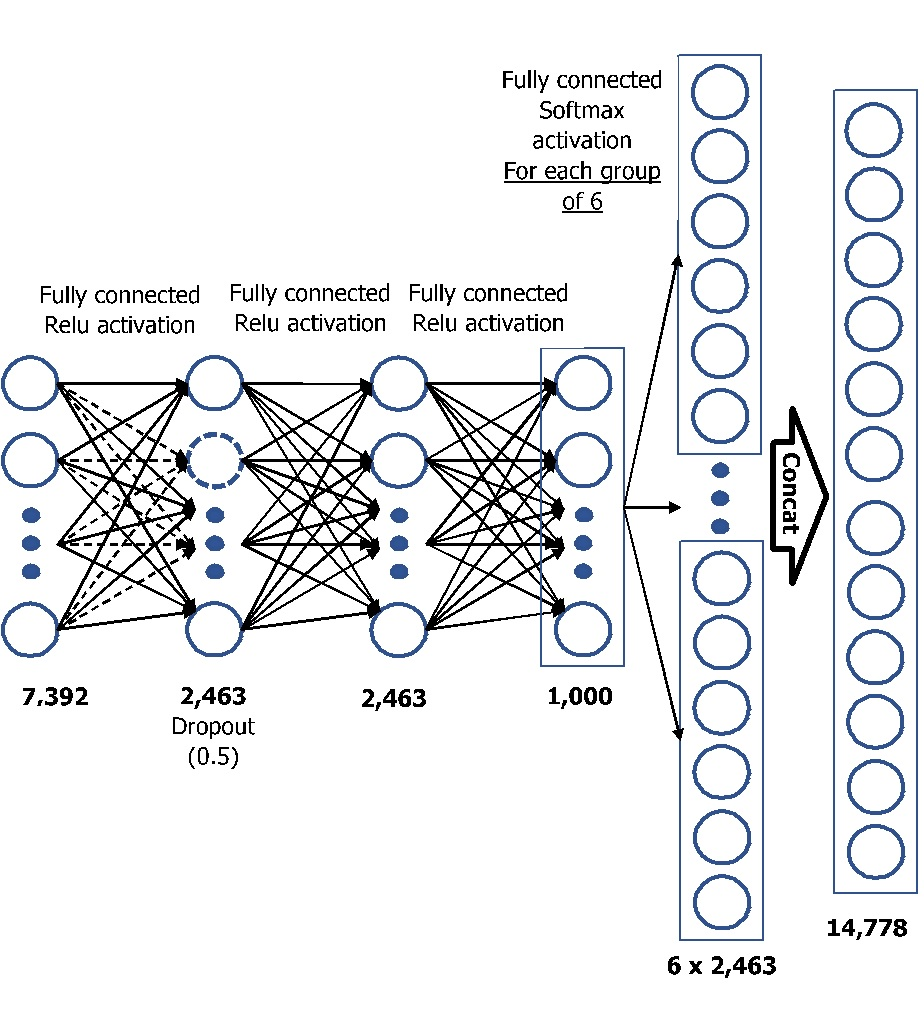

In [ ]:
input_X = keras.layers.Input(shape=(7392,))

Norm = keras.layers.experimental.preprocessing.Normalization()(input_X)
X = keras.layers.Dense(2463, activation="relu",kernel_initializer='glorot_uniform')(Norm)
X = keras.layers.Dropout(0.5)(X)
X = keras.layers.Dense(2463, activation="relu",kernel_initializer='glorot_uniform')(X)
X = keras.layers.Dense(1000, activation="relu",kernel_initializer='glorot_uniform')(X)

partial_sm = []

for i in range(0,2463):
    XSM = keras.layers.Dense(6, activation="softmax")(X)
    partial_sm.append(XSM)

Concat = tf.keras.layers.Concatenate()(partial_sm)

out = Concat

model = keras.models.Model(inputs=input_X, outputs=[out])

In [ ]:
#model.summary()
print(model)

**Custom Loss Fucntion**

We will need a modification on the CategoricalCrossentropy loss sincce we want to evaluate the loss for each municipality (group of six at the output of the network) and sum all the losses to try to minimize them. 

In [ ]:
def custom_crossEnt_loss(y_true, y_pred):
  LossSum = tf.zeros(shape=(), dtype=tf.dtypes.float32)
  cce = tf.keras.losses.CategoricalCrossentropy()
  for i in range(0,2463):
    y_true_piece = y_true[:, i*6:(i+1)*6]
    y_pred_piece = y_pred[:, i*6:(i+1)*6]
    
  
    LossSum = LossSum + cce(y_true_piece,y_pred_piece)

  return LossSum

The following code can print your Neural Network, since ours is too big it will not show it but the code will be kept as comment

In [ ]:
'''
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

from IPython.display import Image
Image(filename='model_plot.png') 
'''

"\nfrom keras.utils.vis_utils import plot_model\nplot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)\n\nfrom IPython.display import Image\nImage(filename='model_plot.png') \n"

Compile the model using 

* loss = CategoricalCrossentropy for each group of six at the output (Custom loss defined above)
* optimizer = Adam

In [ ]:
model.compile(optimizer='adam', 
              loss=custom_crossEnt_loss,
              metrics=['accuracy'])

**Fit the model**

Manual early stopping was used to find a set of weights that achieves the following accuracy:

* Train: 0.9722

* Dev/Val: 0.7097

* Test: 0.6875

Overfitting is present but there are different considerations. More of that in the conclusions.

In [ ]:
model.load_weights('./PartialTrainWeights8_my_checkpoint') 

#Loads previously trained weights to either continue learning or for testing

In [ ]:
model.fit(x=X_Train.T, y=Y_Train.T, 
    epochs=15, 
    batch_size =16,
    validation_data=dev_dataset, 
)

#model.save_weights('./PartialTrainWeights6_my_checkpoint') #Saves the latest weights

In [ ]:
model.save_weights('./PartialTrainWeights_my_checkpoint') #Manually saves weights

**LETS RUN SOME TEST TO SEE HOW IT BEHAVES!**

In [ ]:
model.evaluate(X_Train.T,Y_Train.T)
model.evaluate(X_Dev.T,Y_Dev.T)
model.evaluate(X_Test.T,Y_Test.T)

1/1 [==============================] - 0s 277ms/step - loss: 9957.9092 - accuracy: 0.6875


[9957.9091796875, 0.6875]

**Test against the original Numpy data**

Visualize the predictions of the Dev set

In [ ]:
predictions = model.predict(X_Dev.T)
print(predictions.shape,predictions.dtype)
print(predictions)

(31, 14778) float32
[[9.9970752e-01 4.9340095e-05 8.7927829e-06 ... 1.4719222e-05
  8.1143929e-07 2.1937265e-05]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 5.5981144e-33 1.9447305e-37 ... 4.9298188e-31
  1.7209179e-31 0.0000000e+00]
 ...
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


Save predictions on a csv

In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt

# save to csv file
savetxt('Y_hat_DevTest.csv', predictions, delimiter=',')

SAVE THE MODEL in a .pb file

**ACHTUNG! WARNING!** saving the model requires similar amount of RAM than training/Fit 

In [ ]:
model.save('/content')

INFO:tensorflow:Assets written to: /content/assets


TEST FOR LOADING THE MODEL 

In [ ]:
TestLoadModel = tf.keras.models.load_model('/content')
TestLoadModel.summary()

In [ ]:
model.evaluate(train_dataset)
model.evaluate(dev_dataset)
model.evaluate(test_dataset)

In [ ]:
keras.backend.clear_session() #CLEARS THE SESSION AND RESETS MODEL VALUES

**Conclusion, suggestions, and open questions**

The results are promising but far from perfect, the neural network is learning but the phenomenon that is trying to learn revolves around relationships that are most likely not included in the information given in the dataset. Regardless, a 70% accuracy for the number of municipalities and complexity of the problem seems encouraging. Also, upon further analysis of the results, while accuracy is not perfect, it often misses by 1 the degree of intensity of drought, and it also regularly predicts the general direction (Increase or decrease) of the intensity. 

There are a variety of conclusions that can be drawn from the Programing/machine-learning perspective and from the Environmental-Drought perspective:

* **Related to the Neural Network and working with the same data**

The architecture of the NN could also be modified to a simpler version perhaps and evaluate results. The second hidden layer could be deleted.

Something else that could be done is to assign different weights to the month features (1-12) since they could be more influential. Especially considering that they are just 3 parameters out of 7,392. 

Other ideas include regionalizing the data, diminishing the number of municipalities being train at the same time based on regions. 

A convolutional neural network might be able to obtain similar or better results if the input data was expressed in more dimensions as well as the output, avoiding the problem of slow training because of the loop in the architecture of the Network. I am unclear if this could also represent a more efficient use of RAM. 

* **Related to the phenomenon of drought, the North American Monitor, and the data of origin**

Drought is a phenomenon which dynamics depend on climate cycles with different frequencies on scales that vary between monthly, yearly, quinquennial, and beyond. Because of this fact it is already expected that this experiment that includes information of 3 months would not be able to capture all relevant dynamics, especially those presented in atypical years.

Aside from the 3-month window, the amount of information of the whole set might not be enough to determine certain behaviors/relationships. However, using existing data to acquire more than 144 examples for training might be possible. 

Regarding the North American Drought Monitor, and in particular the version published in Mexico; It is very important to point out that there is a high level of abstraction of the input data X in relationship to the actual phenomenon of drought. The data under which the  model is being trained is the result of multiple preprocessing steps that involve: 

* First, satellite information on climate conditions, vegetation, rainfall gauges and an expert opinion, resulting in a raster-size output
* Second, the political-regionalization of the previous raster-size output, which introduces a spatial dimensions problem since municipalities can be of very different orders of magnitude

It would be very interesting to map all the original data into an input vector (or convolutional input) to attempt to predict the drought intensity based on the raster-size output.  





**Additional Test**

Given all monthly available inputs test predictions in chronological order (used to compare with original downloaded file)

In [ ]:
X_AllChron = pd.read_csv('MunXMonthlyChron.csv', header = None) #Chronological file
X_AllChron = X_AllChron.values

In [ ]:
predictions = model.predict(X_AllChron.T)
print(predictions.shape,predictions.dtype)
print(predictions)

(201, 14778) float32
[[1.0000000e+00 1.0166441e-36 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00 ... 1.0000000e+00
  0.0000000e+00 0.0000000e+00]]


Get the predictions from a concatenation of OneHot vectors to show classes so they can be compared with the original download excel file

In [ ]:
concat = []
for i in range(0,2463):
  y_hat_NonBin_Parcial = np.argmax(predictions[:, i*6:(i+1)*6], axis=1)
  concat.append(y_hat_NonBin_Parcial)

y_hat_NonBin = np.asarray(concat, dtype=np.float32)

print(y_hat_NonBin.shape,predictions.dtype)
print(y_hat_NonBin)

(2463, 201) float32
[[0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 ...
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 2. 2. 2.]
 [0. 0. 0. ... 3. 3. 3.]]


Save both files for comparisson

In [ ]:
# save numpy array as csv file
from numpy import asarray
from numpy import savetxt

# save to csv file
savetxt('Y_hat_AllChron.csv', predictions, delimiter=',')

In [ ]:
# save to csv file
savetxt('y_hat_NonBin_Chron.csv', y_hat_NonBin, delimiter=',')

**Test Next Month**

In [ ]:
X_3Months = pd.read_csv('X_3Months_March.csv', header = None)
X_3Months = X_3Months.values

In [ ]:
predictions = model.predict(X_3Months.T)
print(predictions.shape,predictions.dtype)
print(predictions)

(1, 14778) float32
[[0. 0. 1. ... 1. 0. 0.]]


In [ ]:
concat = []
concatConfid = []
for i in range(0,2463):
  y_hat_Parcial = np.argmax(predictions[:, i*6:(i+1)*6], axis=1)
  concat.append(y_hat_Parcial)
  y_hat_Confidence_Partial = predictions[:,i*6+np.argmax(predictions[:, i*6:(i+1)*6], axis=1)]
  concatConfid.append(y_hat_Confidence_Partial)

y_hat_PredictNextMonth = np.asarray(concat, dtype=np.float32)
y_hat_Confidence = np.asarray( concatConfid, dtype=np.float32).reshape(2463,-1)

y_hat_PredictConfidence = np.concatenate((y_hat_PredictNextMonth, y_hat_Confidence), axis=1)

print(y_hat_PredictNextMonth.shape,y_hat_PredictNextMonth.dtype)
print(y_hat_PredictNextMonth)

#print(y_hat_Confidence.shape,y_hat_Confidence.dtype)
#print(y_hat_Confidence)

#print(y_hat_PredictConfidence.shape,y_hat_PredictConfidence.dtype)
#print(y_hat_PredictConfidence)

In [ ]:
# save to csv file
savetxt('y_hat_PredictNextMonth_April.csv', y_hat_PredictNextMonth, delimiter=',')
savetxt('y_hat_Confidence_April.csv', y_hat_Confidence, delimiter=',')
savetxt('y_hat_PredictConfidence_April.csv', y_hat_PredictConfidence, delimiter=',')